In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py
/kaggle/input/jane-smooth-mynn5-auc-150x3/Jane_mynn5_auc_150_150_150.pth


In [2]:
THREE_HIDDEN_LAYERS = [150, 150, 150]

In [3]:
import os
import gc
import pandas as pd
import numpy as np

import fastai
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.tabular import *
from   fastai.tabular.data import *
from   fastai.tabular.all import *
from   fastai.tabular.all import TabularPandas, RandomSplitter, CategoryBlock, MultiCategoryBlock, range_of, accuracy, tabular_learner, TabularDataLoaders
# from fastai import datasets
# from fastai.dataset import ModelData,ArraysIndexDataset
# from fastai.dataloader import DataLoader
from   fastai.learner import Learner
from   fastai.metrics import RocAucMulti

from   sklearn.pipeline import Pipeline
from   sklearn.impute import SimpleImputer
from   sklearn.preprocessing import StandardScaler

import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss

from   functools import partial
import warnings
warnings.filterwarnings ("ignore")

In [4]:
# Global Vars
TP   = None
DF   = None
DLs  = None
PIPE = None
BS   = 10000
N_FEATURES  = 0
N_FEAT_TAGS = 0

In [5]:
dtype = {
    'feature'  : 'str', 
    'tag_0'    : 'int8'
}
for i in range (1, 29):
    k = 'tag_' + str (i)
    dtype[k] = 'int8'
    
features_df = pd.read_csv ('../input/jane-street-market-prediction/features.csv', usecols=range (1,30), dtype=dtype)
N_FEATURES  = features_df.shape[0]  # the features.csv has 130 features (1st row) = no of features in train.csv (feature_0 to feature_129)
N_FEAT_TAGS = features_df.shape[1]  # the features.csv has 29 tags

# features_df.head ()
del features_df
gc.collect ()
N_FEATURES, N_FEAT_TAGS

(130, 29)

In [6]:
def preprocess_data (filename='../input/jane-street-market-prediction/train.csv', df=None, isTrainData=True):
    
    global PIPE
    dtype = None
    if isTrainData:
        
        dtype = {
            'date'      : 'int64', 
            'weight'    : 'float32',
            'resp'      : 'float32',
            'ts_id'     : 'int64',  
            'feature_0' : 'float32'
        }
    else:
        
        dtype = {
            'date'      : 'int64', 
            'weight'    : 'float32',
            'feature_0' : 'float32'
        }
    for i in range (1, 130):
        k = 'feature_' + str (i)
        dtype[k] = 'float32'
    
    to   = None
    if isTrainData:
        df         = pd.read_csv (filename, dtype=dtype)
        df         = df.query ('date > 85')
        # df       = df[df['weight'] != 0].reset_index (drop = True)
        df         = df.reset_index (drop = True)
        
        resp_cols  = ['resp_1', 'resp_2', 'resp_3','resp_4', 'resp']    
        # df[:5000].to_csv (filename+'.dummy', index=False) 
        y          = np.stack ([(df[c] > 0).astype ('int') for c in resp_cols]).T
        df.drop (columns=['weight', 'date', 'ts_id']+resp_cols, inplace=True)
        f_columns  = [c for c in df.columns if "feature" in c]
        PIPE       = Pipeline ([
                        ("imputer", SimpleImputer (missing_values=np.nan, strategy='mean')),
                        # ("stand",   StandardScaler (with_mean=False))
        ])
        columns    = list (df.columns) + resp_cols
        X          = PIPE.fit_transform (df)
        df         = pd.DataFrame (np.hstack ((X, y)))
        df.columns = columns
        del X, y

        splits    = RandomSplitter (valid_pct=0.05) (range_of (df))
        to        = TabularPandas (df, cont_names=f_columns, cat_names=None, y_names=resp_cols, y_block=MultiCategoryBlock(encoded=True, vocab=resp_cols), splits=splits)
    else:
        
        df         = df.drop (columns=['weight', 'date']).reset_index (drop = True)
        columns    = df.columns
        X          = PIPE.transform (df)
        df         = pd.DataFrame (X)
        df.columns = columns
        # del X
    return to, df

In [7]:
TP, DF = preprocess_data ()
TP.xs.iloc[:2]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
170319,1.0,-0.626267,0.701399,0.066734,0.18129,-0.280767,-0.503351,0.035757,0.026819,-3.246021,...,-0.336935,3.563445,-0.592358,1.996581,-0.327662,3.582018,-0.665957,2.405868,-0.688863,1.908013
1592740,-1.0,0.917211,-0.563204,3.863085,2.16912,2.752535,1.506814,-0.695089,-0.603372,1.313784,...,2.411277,-1.848157,2.169856,-1.569392,2.873893,-1.058531,3.945661,-0.833883,2.470642,-1.495841


In [8]:
TP.ys.iloc[:2]

,resp_1,resp_2,resp_3,resp_4,resp
170319,1.0,1.0,1.0,1.0,1.0
1592740,0.0,0.0,0.0,0.0,0.0


In [9]:
TP.xs.shape, TP.ys.shape

((1862597, 130), (1862597, 5))

In [10]:
DLs = TP.dataloaders (bs=BS)
DLs.show_batch ()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,resp_1,resp_2,resp_3,resp_4,resp
0,1.0,-1.900768,-1.608544,-1.192979,-1.583602,-0.503493,-0.684621,0.112670,0.335127,-2.262793,-1.369675,-0.048306,0.251339,-0.030837,0.436558,-0.887494,-0.852812,0.328173,0.710024,-0.034046,0.012062,0.806868,0.877899,0.652580,1.370531,0.270316,0.547014,-0.052544,-0.158554,-0.141807,-0.210039,-0.005259,-0.022152,-0.035598,-0.059704,-0.121218,-0.162274,0.636442,1.045536,-1.196004,-2.833842,1.009266,-1.866562,-1.212851,0.395758,2.711383,-0.607383,-2.060877,-1.581543,-1.123576,-0.094332,-0.621297,-0.455841,-3.106137,-2.127680,-1.258713,-0.470421,-2.188391,-2.293986,-1.140770,5.939357,5.489433,0.105329,0.105154,3.930053,-0.107512,-0.076984,5.620334,5.521549,-2.028198,-1.568960,-1.343842,0.433198,-0.144225,-0.126671,-0.402584,-0.363158,1.215789,2.741147,-0.662356,-0.968448,-2.687588,-1.675929,3.852347,-0.132972,-1.238212,-0.354839,-1.790914,-1.641860,0.333546,2.816981,-1.515613,1.623332,-1.322749,-1.086886,4.831050,-0.531097,-0.198116,-0.368223,-0.274125,-0.081362,0.089853,2.449982,0.702139,1.786539,1.740541,2.466492,4.221963,-0.582577,-2.490699,-0.425758,-0.942799,-1.913909,0.243618,2.545172,-0.441048,2.230573,1.080130,0.985384,3.780184,-2.402171,-2.789730,-2.888917,-2.216867,-2.208302,-3.183659,-3.795280,-2.073800,-2.979951,-1.586416,False,False,True,True,False
1,-1.0,-0.119798,-1.198306,-2.292456,-1.361552,-1.810592,-1.064253,0.547304,0.136837,0.968432,-0.257487,0.592645,0.114178,2.863122,1.281541,0.644722,-0.365720,-0.338769,-0.259642,-1.043231,-0.797960,-0.959002,-0.301754,-1.053599,-0.749294,-1.305945,-0.879145,1.355182,1.203300,2.127151,1.484071,2.516853,2.537592,3.390670,2.287302,2.642089,1.400093,-3.071107,-2.280042,0.663619,0.564429,-1.111940,1.966870,2.821140,0.629690,-0.218145,1.014766,2.779717,1.915370,0.920625,0.529433,-0.453779,1.505407,4.064773,2.535147,-0.819800,-0.458274,-0.404925,0.440241,0.609979,-0.543902,-0.462340,3.074103,3.166838,1.646291,2.923996,2.532566,0.741577,0.732292,0.516208,-1.547434,-0.545700,0.233428,0.936801,0.576461,0.640188,0.898540,-3.997144,0.261665,0.407164,0.442980,0.490790,0.384145,-2.664633,0.229546,1.086425,0.377922,0.037129,0.765208,0.623979,-0.426210,0.443464,-0.123997,-0.568871,-0.027033,-0.090918,0.127650,-1.338859,-0.147343,-1.257774,-1.194013,1.409824,-0.693190,-0.940190,-0.531404,-1.510224,-1.781693,0.617417,0.253509,-0.357043,0.112614,-0.673054,-0.712418,1.341554,-0.557055,-1.199819,-0.573890,-2.326893,-1.591837,0.222543,1.682669,0.165730,3.901945,2.385803,1.717541,0.406132,3.403403,1.167961,4.220600,2.132877,True,True,True,T

In [11]:
DLs.one_batch ()[2].shape

torch.Size([10000, 5])

In [12]:
x_cat, x_cont, y = DLs.train.one_batch ()
x_cat.shape, x_cont.shape, y.shape

(torch.Size([10000, 0]), torch.Size([10000, 130]), torch.Size([10000, 5]))

# Custom Model

In [13]:
class SmoothBCEwLogits(_WeightedLoss):
    
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [14]:
class FFN (nn.Module):
    
    def __init__(self, inputCount=130, outputCount=5, hiddenLayerCounts=[150, 150, 150], 
                 drop_prob=0.5, nonlin=nn.SiLU (), isOpAct=False):
        
        super(FFN, self).__init__()
        
        self.nonlin     = nonlin
        self.dropout    = nn.Dropout (drop_prob)
        self.batchnorm0 = nn.BatchNorm1d (inputCount)
        self.dense1     = nn.Linear (inputCount, hiddenLayerCounts[0])
        self.batchnorm1 = nn.BatchNorm1d (hiddenLayerCounts[0])
        self.dense2     = nn.Linear(hiddenLayerCounts[0], hiddenLayerCounts[1])
        self.batchnorm2 = nn.BatchNorm1d (hiddenLayerCounts[1])
        self.dense3     = nn.Linear(hiddenLayerCounts[1], hiddenLayerCounts[2])
        self.batchnorm3 = nn.BatchNorm1d (hiddenLayerCounts[2])        
        self.outDense   = None
        if outputCount > 0:
            self.outDense   = nn.Linear (hiddenLayerCounts[-1], outputCount)
        self.outActivtn = None
        if isOpAct:
            if outputCount == 1 or outputCount == 2:
                self.outActivtn = nn.Sigmoid ()
            elif outputCount > 0:
                self.outActivtn = nn.Softmax (dim=-1)
        return

    def forward (self, X):
        
        X = self.dropout (self.batchnorm0 (X))
        X = self.dropout (self.nonlin (self.batchnorm1 (self.dense1 (X))))
        X = self.dropout (self.nonlin (self.batchnorm2 (self.dense2 (X))))
        X = self.dropout (self.nonlin (self.batchnorm3 (self.dense3 (X))))
        if self.outDense:
            X = self.outDense (X)
        if self.outActivtn:
            X = self.outActivtn (X)
        return X

In [15]:
class Emb_NN_Model (nn.Module):
    
    def __init__(self, three_hidden_layers=THREE_HIDDEN_LAYERS, embed_dim=(N_FEAT_TAGS//2+1), csv_file='../input/jane-street-market-prediction/features.csv'):
        
        super (Emb_NN_Model, self).__init__()
        global N_FEAT_TAGS
        N_FEAT_TAGS = 29
        
        # store the features to tags mapping as a datframe tdf, feature_i mapping is in tdf[i, :]
        dtype = {'tag_0' : 'int8'}
        for i in range (1, 29):
            k = 'tag_' + str (i)
            dtype[k] = 'int8'
        t_df = pd.read_csv (csv_file, usecols=range (1,N_FEAT_TAGS+1), dtype=dtype)
        t_df['tag_29'] = np.array ([1] + ([0] * (t_df.shape[0]-1)) ).astype ('int8')
        self.features_tag_matrix = torch.tensor (t_df.to_numpy ())
        N_FEAT_TAGS += 1
        
        # print ('self.features_tag_matrix =', self.features_tag_matrix)
        
        # embeddings for the tags. Each feature is taken a an embedding which is an avg. of its' tag embeddings
        self.embed_dim     = embed_dim
        self.tag_embedding = nn.Embedding (N_FEAT_TAGS+1, embed_dim) # create a special tag if not known tag for any feature
        self.tag_weights   = nn.Linear (N_FEAT_TAGS, 1)
        
        self.dropout       = nn.Dropout (0.5)
        # self.layer_normal= nn.LayerNorm (embed_dim) 
        self.ffn           = FFN (inputCount=(130+embed_dim), outputCount=0, hiddenLayerCounts=[(three_hidden_layers[0]+embed_dim), (three_hidden_layers[1]+embed_dim), (three_hidden_layers[2]+embed_dim)], drop_prob=0.2)
        self.outDense      = nn.Linear (three_hidden_layers[2]+embed_dim, 5)
        # self.outActivtn  = nn.LogSoftmax (dim=1)                  # not used
        self.criterion     = nn.BCEWithLogitsLoss ()    # nn.NLLLoss ()
        return
    
    def features2emb (self):
        """
        idx : int feature index 0 to N_FEATURES-1 (129)
        """
        
        all_tag_idxs = torch.LongTensor (np.arange (N_FEAT_TAGS)) #.to (DEVICE)              # (29,)
        tag_bools    = self.features_tag_matrix                                # (130, 29)
        # print ('tag_bools.shape =', tag_bools.size())
        f_emb        = self.tag_embedding (all_tag_idxs).repeat (130, 1, 1)    #;print ('1. f_emb =', f_emb) # (29, 7) * (130, 1, 1) = (130, 29, 7)
        # print ('f_emb.shape =', f_emb.size())
        f_emb        = f_emb * tag_bools[:, :, None]                           #;print ('2. f_emb =', f_emb) # (130, 29, 7) * (130, 29, 1) = (130, 29, 7)
        # print ('f_emb.shape =', f_emb.size())
        
        # Take avg. of all the present tag's embeddings to get the embedding for a feature
        s = torch.sum (tag_bools, dim=1)                                       # (130,)
        # print ('s =', s)              
        f_emb = torch.sum (f_emb, dim=-2) / s[:, None]                         # (130, 7)
        # print ('f_emb =', f_emb)        
        # print ('f_emb.shape =', f_emb.shape)
        
        # take a linear combination of the present tag's embeddings
        # f_emb = f_emb.permute (0, 2, 1)                                        # (130, 7, 29)
        # f_emb = self.tag_weights (f_emb)                      #;print ('3. f_emb =', f_emb)                 # (130, 7, 1)
        # f_emb = torch.squeeze (f_emb, dim=-1)                 #;print ('4. f_emb =', f_emb)                 # (130, 7)
        return f_emb
    
    def forward (self, cat_featrs, features):
        """
        when you call `model (x ,y, z, ...)` then this method is invoked
        """
        
        cat_featrs = None
        features   = features.view (-1, N_FEATURES)
        f_emb      = self.features2emb ()                                #;print ('5. f_emb =', f_emb); print ('6. features =', features) # (130, 7)
        # print ('features.shape =', features.shape, 'f_emb.shape =', f_emb.shape)
        features_2 = torch.matmul (features, f_emb)                      #;print ('7. features =', features) # (1, 130) * (130, 7) = (1, 7)
        # print ('features.shape =', features.shape)
        
        # Concatenate the two features (features + their embeddings)
        features   = torch.hstack ((features, features_2))        
        
        x          = self.ffn (features)                               #;print ('8. x.shape = ', x.shape, 'x =', x)   # (1, 7) -> (1, 7)
        # x        = self.layer_normal (x + features)                  #;print ('9. x.shape = ', x.shape, 'x =', x)   # (1, 7) -> (1, 2)
        out_logits = self.outDense (x)                                 #;print ('10. out_
        out_logits = self.outDense (x)                                 #;print ('10. out_logits.shape = ', out_logits.shape, 'out_logits =', out_logits)        
        # return sigmoid probs
        # out_probs = F.sigmoid (out_logits)
        return out_logits

In [16]:
# for vanilla NN use this
# path  = "../input/jane-smooth-mynn5-auc-150x3/Jane_mynn5_auc_150_150_150"
learn = TabularLearner (DLs, model=Emb_NN_Model (), 
                        loss_func=SmoothBCEwLogits (smoothing=0.01), metrics=RocAucMulti ())  #, model_dir='/kaggle/working/')
# learn = learn.load (path)
learn.summary ()

Emb_NN_Model (Input shape: 10000 x torch.Size([10000, 130]))
Layer (type)         Output Shape         Param #    Trainable 
                     10000 x 15          
Embedding                                 465        True      
SiLU                                                           
Dropout                                                        
BatchNorm1d                               290        True      
____________________________________________________________________________
                     10000 x 165         
Linear                                    24090      True      
BatchNorm1d                               330        True      
Linear                                    27390      True      
BatchNorm1d                               330        True      
Linear                                    27390      True      
BatchNorm1d                               330        True      
__________________________________________________________________________

In [17]:
logits = learn.model (x_cat, x_cont)
logits

tensor([[ 0.0180, -0.3151,  0.2907, -0.3141, -0.1450],
        [ 0.1066, -0.1159, -0.0942, -0.2673, -0.0141],
        [-0.0094,  0.2449,  0.1010, -0.3073, -0.1495],
        ...,
        [-0.0616,  0.1813,  0.0150, -0.4099, -0.0189],
        [ 0.0475,  0.1005, -0.0306,  0.0362, -0.0713],
        [ 0.1140,  0.0008,  0.0221, -0.3799,  0.2226]],
       grad_fn=<AddmmBackward>)

In [18]:
x_cat, x_cont, y = learn.dls.one_batch ()
init_loss = learn.loss_func (learn.model (x_cat, x_cont), y)
init_loss

tensor(0.7065, grad_fn=<MeanBackward0>)

(0.00660693421959877, 0.0001995262282434851)

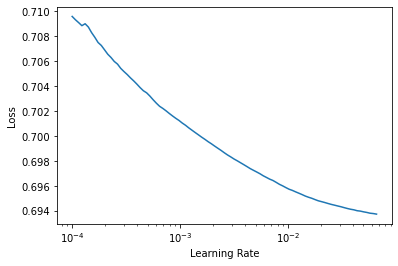

In [19]:
lr_min, lr_steep = learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)
lr_min, lr_steep

In [20]:
modelfile='Jane_EmbNN5_auc_'+str (THREE_HIDDEN_LAYERS).replace (' ', '_').replace (',', '').replace ('[', '').replace (']', '')
callbacks = [
    EarlyStoppingCallback (monitor='roc_auc_score', min_delta=0.0001, patience=10),
    SaveModelCallback (monitor='roc_auc_score', fname=modelfile),
    ReduceLROnPlateau (monitor='roc_auc_score', min_delta=0.0001, factor=2.0, min_lr=1e-5, patience=1),
    GradientClip (0.1)
]

epochs  = 90
lr      = lr_min
learn.fit_one_cycle (epochs, lr, wd=6e-2, cbs=callbacks)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.693266,0.690621,0.539331,00:56
1,0.691364,0.690073,0.543208,00:55
2,0.690641,0.689780,0.545179,00:52
3,0.690224,0.689449,0.547313,00:54
4,0.689951,0.689309,0.548386,00:56
5,0.689745,0.689016,0.549892,00:55
6,0.689705,0.688908,0.550477,00:56
7,0.689554,0.688809,0.551424,00:55
8,0.689311,0.688534,0.551587,00:54
9,0.689277,0.688393,0.553347,00:53


Better model found at epoch 0 with roc_auc_score value: 0.5393306165134708.
Better model found at epoch 1 with roc_auc_score value: 0.5432083169072038.
Better model found at epoch 2 with roc_auc_score value: 0.5451790617297466.
Better model found at epoch 3 with roc_auc_score value: 0.5473125130998624.
Better model found at epoch 4 with roc_auc_score value: 0.5483856070397012.
Better model found at epoch 5 with roc_auc_score value: 0.5498924654724645.
Better model found at epoch 6 with roc_auc_score value: 0.5504767243268122.
Better model found at epoch 7 with roc_auc_score value: 0.5514243186144696.
Better model found at epoch 8 with roc_auc_score value: 0.5515873990346305.
Better model found at epoch 9 with roc_auc_score value: 0.5533466278198108.
Epoch 10: reducing lr to 0.0016612068946106093
Epoch 11: reducing lr to 0.0018822988629380707
Better model found at epoch 12 with roc_auc_score value: 0.5544159048377323.
Better model found at epoch 13 with roc_auc_score value: 0.5565066281

In [21]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

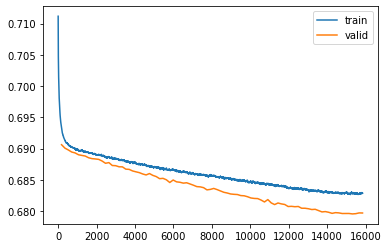

In [22]:
learn.recorder.plot_loss (skip_start=0, with_valid=True)

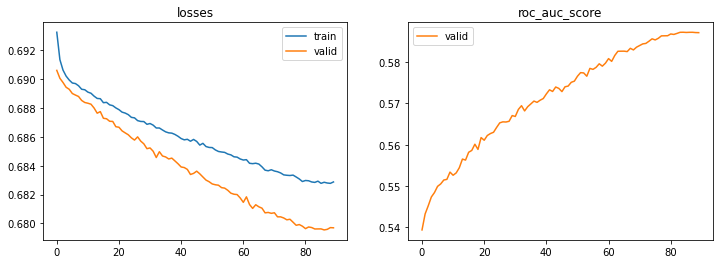

In [23]:
learn.recorder.plot_metrics ()

lr_min, lr_steep = learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)
lr_min, lr_steep

epochs  = 80
lr      = lr_min
learn.fit_one_cycle (epochs, lr, wd=1e-2, cbs=callbacks)

lr_min, lr_steep = learn.lr_find (start_lr=1e-4, end_lr=0.1, num_it=100)
lr_min, lr_steep

epochs  = 30
lr      = lr_min
learn.fit_one_cycle (epochs, lr, wd=1e-2, cbs=callbacks)

In [24]:
# learn.recorder.plot_lr ()

In [25]:
# _, logits, _ = learn.predict (DF.iloc[0])
# logits

# Prediction

In [26]:
MODEL = learn.model.eval ()
MODEL

Emb_NN_Model(
  (tag_embedding): Embedding(31, 15)
  (tag_weights): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (ffn): FFN(
    (nonlin): SiLU()
    (dropout): Dropout(p=0.2, inplace=False)
    (batchnorm0): BatchNorm1d(145, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense1): Linear(in_features=145, out_features=165, bias=True)
    (batchnorm1): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense2): Linear(in_features=165, out_features=165, bias=True)
    (batchnorm2): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense3): Linear(in_features=165, out_features=165, bias=True)
    (batchnorm3): BatchNorm1d(165, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outDense): Linear(in_features=165, out_features=5, bias=True)
  (criterion): BCEWithLogitsLoss()
)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from   torch.autograd import Variable
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

DEVICE = torch.device ("cuda:0") if torch.cuda.is_available () else torch.device ("cpu")

# For direct submission, without using Fastai since its too slow
Use Fastai for training models only, not for prediction.

In [28]:
def predict_torch (test_df):
    
    test_df.drop (columns=['weight', 'date'], inplace=True)
    test_df.reset_index (drop=True, inplace=True)
    test_df = PIPE.transform (test_df)        
    test_df = torch.tensor (test_df).float ().view (-1, 130)
    predictions = []
    for i in range (test_df.shape[0]):
        
        pred_p = torch.sigmoid (MODEL (None, test_df)).detach ().cpu ().numpy ().reshape ((-1, 5))
        predictions.append (pred_p)

    predictions = np.vstack (predictions)                     #;print ('predictions.shape =', predictions.shape)
    predictions = np.median (predictions, axis=1)
    return (predictions >= 0.5).astype (int)

# For prediction using Fastai
Don't use thism its too slow and times out. Use Pytorch for prediction.
Use Fastai for training the Pytorch models only.

In [29]:
import torch.nn.functional as F

def predict (df, threshold=0.50):
    
    dl     = learn.dls.test_dl (df)
    logits = learn.get_preds (dl=dl)[0]
    probs  = F.sigmoid (logits).detach ().numpy ()
    pred   = (np.median (probs, axis=1) >= threshold).astype (int)
    return pred

test_df = DF.copy()
resp_cols  = ['resp_1', 'resp_2', 'resp_3','resp_4', 'resp']
test_df.drop (columns=resp_cols, inplace=True)

test_df  = preprocess_data (df=test_df, isTrainData=False)
predict (test_df)

# Test

In [30]:
import janestreet
env      = janestreet.make_env ()  # initialize the environment
env_iter = env.iter_test ()        # an iterator which loops over the test set

In [31]:
for test_df, pred_df in env_iter:
    if test_df["weight"].item () > 0:
        
        pred_df.action = predict_torch (test_df)
    else:
        pred_df.action = 0
        
    # print (pred_df)
    # print ("--------------")
    env.predict (pred_df)

In [32]:
print ('Done !')

Done !
